Importando bibliotecas




In [ ]:
import pandas as pd
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine
import numpy as np
import networkx as nx
!pip install plotly.express
from plotly import graph_objs as go

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Remoção de stopwords

In [ ]:
# remoção de pontuacao e stopwords

def remove_stopwords(text,lang,domain_stopwords=[]):
  
  stop_words = nltk.corpus.stopwords.words(lang) # lang='portuguese' or lang='english'
  
  s = str(text).lower() # tudo para caixa baixa
  table = str.maketrans({key: None for key in string.punctuation})
  s = s.translate(table) # remove pontuacao
  tokens = word_tokenize(s) #obtem tokens
  v = [i for i in tokens if not i in stop_words and not i in domain_stopwords and not i.isdigit()] # remove stopwords
  s = ""
  for token in v:
    s += token+" "
  return s.strip()


Stemming/Radicalização de Termos

In [ ]:
# stemming
def stemming(text,lang):
  
  stemmer = PorterStemmer() # stemming para ingles
  
  if lang=='portuguese':
    stemmer = nltk.stem.RSLPStemmer() # stemming para portuguese
    
  tokens = word_tokenize(text) #obtem tokens
  
  sentence_stem = ''
  doc_text_stems = [stemmer.stem(i) for i in tokens]
  for stem in doc_text_stems:
    sentence_stem += stem+" "
    
  return sentence_stem.strip()

Base de Textos - Pedidos e recursos de acesso à informação

In [ ]:
# Leitura dos dados (recursos)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [ ]:
pd.set_option('max_colum', 100)

In [ ]:
df = pd.read_csv('dados_processados-full.csv')

In [ ]:
df['DataResposta_3g'] = pd.to_datetime(df['DataResposta_3g'], infer_datetime_format=True, yearfirst=True)

In [ ]:
df = df.sort_values(by='DataResposta_3g', ascending=True)

In [ ]:
df['DataResposta_3g'].tail()

7837    2021-03-31
2006    2021-03-31
11719   2021-03-31
4468    2021-03-31
5142    2021-04-05
Name: DataResposta_3g, dtype: datetime64[ns]

In [ ]:
df['DataResposta_3g'].head()

154     2012-09-03
11907   2012-09-10
5649    2012-09-10
8086    2012-09-21
7776    2012-09-21
Name: DataResposta_3g, dtype: datetime64[ns]

In [ ]:
df.shape

(12869, 76)

In [ ]:
# Nesse projeto selecionamos as datas maiores que 01/01/2019
selecao = (df['DataResposta_3g'] >= '2019-01-01') 

df_filtrado = df[selecao]


In [ ]:
df_filtrado['DataResposta_3g'] 

11625   2019-01-02
2345    2019-01-02
5066    2019-01-02
1901    2019-01-02
831     2019-01-02
           ...    
7837    2021-03-31
2006    2021-03-31
11719   2021-03-31
4468    2021-03-31
5142    2021-04-05
Name: DataResposta_3g, Length: 3862, dtype: datetime64[ns]

In [ ]:
df = df_filtrado
df.shape

(3862, 76)

In [ ]:
df.columns

Index(['IdRecurso_3g', 'IdRecursoPrecedente_3g', 'DescRecurso_3g',
       'OrgaoDestinatario_3g', 'Instancia_3g', 'Situacao_3g',
       'DataRegistro_3g', 'PrazoAtendiment_3g', 'OrigemSolicitacao_3g',
       'TipoRecurso_3g', 'DataResposta_3g', 'RespostaRecurso_3g',
       'TipoResposta_3g', 'NomesAnexosCidadao_3g', 'NomeAnexosSIC_3g',
       'IdRecurso_2g', 'IdRecursoPrecedente_2g', 'DescRecurso_2g',
       'OrgaoDestinatario_2g', 'Instancia_2g', 'Situacao_2g',
       'DataRegistro_2g', 'PrazoAtendiment_2g', 'OrigemSolicitacao_2g',
       'TipoRecurso_2g', 'DataResposta_2g', 'RespostaRecurso_2g',
       'TipoResposta_2g', 'NomesAnexosCidadao_2g', 'NomeAnexosSIC_2g',
       'IdRecurso_1g', 'DescRecurso_1g', 'ProtocoloPedido',
       'OrgaoDestinatario_1g', 'Instancia_1g', 'Situacao_1g',
       'DataRegistro_1g', 'PrazoAtendiment_1g', 'OrigemSolicitacao_1g',
       'TipoRecurso_1g', 'DataResposta_1g', 'RespostaRecurso_1g',
       'TipoResposta_1g', 'NomesAnexosCidadao_1g', 'NomeAnexosSI

In [ ]:
df['conhecido'].value_counts(normalize=True)

1    0.608234
0    0.391766
Name: conhecido, dtype: float64

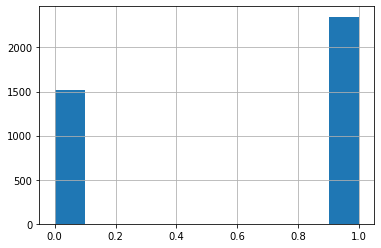

In [ ]:
df.conhecido.hist()

In [ ]:
dataset = df[(df.conhecido==1) | (df.conhecido==0)][['IdSolicitante','DataRegistro_0g', 'IdPedido','IdRecurso_3g','DetalhamentoSolicitacao','conhecido']].dropna()

In [ ]:
dataset.reset_index(inplace=True,drop=True)
dataset

,IdSolicitante,DataRegistro_0g,IdPedido,IdRecurso_3g,DetalhamentoSolicitacao,conhecido
0,1134616.0,2018-11-28,1619838,77625,"À ANEEL Senhores, Conforme é do conhecimento d...",1
1,2752629.0,2018-11-14,1615894,77370,Considerando que o Comitê Gestor é quem possui...,0
2,2714933.0,2018-09-19,1594915,74591,Fiz repetidos pedidos de informação à Fundação...,1
3,192494.0,2018-10-22,1605996,73346,"Prezados Senhores, Bom dia. Solicito cópia, em...",0
4,2920208.0,2018-11-07,1611921,73355,"Prezados Senhores, recentemente através do ped...",0
...,...,...,...,...,...,...
3856,4080794.0,2021-02-10,2902715,133780,"Prezado(a) Sr.(a), Objetivando compreender os ...",0
3857,0.0,2020-12-29,2789455,132898,"Prezados, Recentemente a nação brasileira tem ...",1
3858,2829420.0,2020-12-16,2760270,132971,"Caras e Caros da SNDAPI, Ano passado a Secreta...",1
3859,3100284.0,2021-02-10,2905773,134373,SOLICITO INFORMAÇÕES E RESPOSTAS AOS QUESTIONA...,0


In [ ]:
dataset.IdSolicitante[2269]

3172106.0

In [ ]:
dataset.DataRegistro_0g[2269]

'2020-03-03'

Computando uma Bag-of-Words e aplicando TFIDF

In [ ]:
# obtendo a VSM com TFIDF
def compute_vsm_tfidf(dataset,lang,domain_stopwords=[]):
  
  d = []
  for index,row in dataset.iterrows():
    text = row['DetalhamentoSolicitacao'] 
    text2 = remove_stopwords(text, lang,domain_stopwords)
    text3 = stemming(text2, lang)
    d.append(text3)
  
  matrix = TfidfVectorizer(max_features=500)
  X = matrix.fit_transform(d)
  
  tfidf_vect_df = pd.DataFrame(X.todense(), columns=matrix.get_feature_names())

  return tfidf_vect_df


vsm = compute_vsm_tfidf(dataset,'portuguese')
vsm

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,1º,2º,3º,5º,7º,abaix,abert,abril,acess,acim,acompanh,acord,administr,adot,agent,agradeç,aguard,agênc,aind,algum,alter,alun,além,amazôn,ancin,anex,ano,ant,anteri,anvis,anális,apen,aplic,apont,aposentad,apresent,aprov,apur,após,arqu,art,artig,assim,assin,assunt,ata,atencios,atend,atenç,ativ,...,sob,sobr,soc,solic,solicit,soment,sr,superi,suspens,tabel,tal,tard,te,tem,temp,tend,ter,terc,term,tip,tod,tom,total,trabalh,transfer,transpar,trat,tud,técn,uni,unidad,univers,uso,utiliz,vag,val,vem,venh,verb,vez,via,vid,vincul,vist,áre,âmbit,íntegr,órg,últ,únic
0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.085218,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.075318,0.074312,0.0,0.0,0.085100,0.070418,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.068263,0.000000,0.000000,0.000000,0.000000,0.101652,0.0,0.000000,0.00000,0.094639,0.000000,0.000000,0.000000,0.207855,0.0,0.000000,0.0,0.050677,0.0,0.000000,0.000000,0.000000,0.000000,0.071189,0.000000,0.000000,0.000000,0.000000,0.000000,0.100635,0.000000,0.000000,0.068002,0.085941,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.0,0.000000,0.189724,0.000000,0.000000,0.000000,0.091438,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.107162,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.132264,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.063426,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.166785,0.000000,0.0,0.127864,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.143825,0.000000,0.142979,0.000000,0.000000,0.000000,0.000000,0.154304,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.199485,0.000000,0.152019,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.092315,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.076075,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.068624,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.075787,0.0,0.0,0.000000,0.000000,0.078615,0.000000,0.0,...,0.087647,0.000000,0.000000,0.000000,0.064035,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.084193,0.211982,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.092865,0.000000,0.000000,0.000000,0.000000,0.082263,0.084299,0.000000,0.000000,0.000000,0.069352,0.000000,0.000000,0.0,0.084840,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.238453,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.089404,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.144318,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.052258,0.105874,0.0,0.096178,0.000000,0.104602,0.0,0.000000,0.0,0.000000,0.000000,0.172261,0.0,0.0,0.0000,0.0,0.0,0.061245,0.065377,0.0,0.000000,0.000000,0.000000,0.192857,0.0,0.000000,0.0,0.000000,0.

Preparando dados para classificador kNN

In [ ]:
X = np.array(vsm)
length = np.sqrt((X**2).sum(axis=1))[:,None]
X = X / (length+0.00001)

X.shape

(3861, 500)

In [ ]:
X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03047262, 0.        , ..., 0.04639078, 0.08551862,
        0.06941698],
       [0.20973723, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
Y = dataset['conhecido'].to_list()


Vamos usar 80% (treino) e 20% (teste)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

In [ ]:
neigh.score(X_test,y_test)

0.6934023285899095

In [ ]:
from sklearn.metrics import f1_score
# predict
y_pred = neigh.predict(X_test)

# f1 score
score = f1_score(y_pred, y_test)

score

0.7766258246936852

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.43      0.51       286
           1       0.72      0.85      0.78       487

    accuracy                           0.69       773
   macro avg       0.67      0.64      0.64       773
weighted avg       0.68      0.69      0.68       773



In [ ]:
from sklearn.model_selection import GridSearchCV
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_neighbors": np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [ ]:
#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 11}

In [ ]:
#check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

0.6881486260378803

In [ ]:
from sklearn.metrics import f1_score
# predict
y_pred = knn_gscv.predict(X_test)

# f1 score
score = f1_score(y_pred, y_test)

score

0.7743785850860421

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.46      0.53       286
           1       0.72      0.83      0.77       487

    accuracy                           0.69       773
   macro avg       0.67      0.65      0.65       773
weighted avg       0.68      0.69      0.68       773



In [ ]:
# computando dissimilaridade de cosseno

def dis_cosine(matrix, e1, e2):
  dcos = cosine(matrix.iloc[e1,:], matrix.iloc[e2,:])
  return dcos




In [ ]:
# exemplo: similaride entre o primeiro (id=0) e o último evento (id=1) do vsm-tfidf
dis_cosine(vsm,0,2850)

0.8068203092593178

In [ ]:
dataset.DetalhamentoSolicitacao[0]

'À ANEEL Senhores, Conforme é do conhecimento de V.Sa. foi informado nos documentos públicos Ofício 665/2018-SMA/ANEEL de 24/09/2018 entregue em 03/10/2018 ao consulente e na Comunicação da Ouvidoria nº 213848/2018-SMA/ANEEL, informação oficial de que a concessionária havia cancelada a cobrança existente. Recebi e-mail informando que a Concessionária havia informado ao consumidor “equivocadamente” de que a cobrança havia sido cancelada e não suspensa. Registramos que esta comunicação não foi recebida pela consumidora. Se a concessionária informou a ANEEL que a cobrança havia sido “cancelada” deve tê-la feito, por carta, por e-mail, em reunião cujo teor e decisão deverá ter constado de ata, ou seja, toda tratativa como foi o caso de cancelamento da cobrança devem, s.m.j., ser através de correspondência por escrito e formal e seguir os trâmites legais referente ao serviço público e em especial aos princípios do artigo 37 da Constituição Federal. Assim, pelo exposto, e por ter sido o dest

In [ ]:
dataset.DetalhamentoSolicitacao[2850]

'Com fundamento na Lei 12.527/2011 (Lei de Acesso a Informações Públicas) venho requerer o acesso (e eventualmente cópia), em até 20 dias corridos (artigo 11, parágrafo 1º da Lei 12.527/11), aos seguintes dados: Solicito acesso a pareceres, memorandos, notas técnicas e demais documentos relacionados à declaração da ministra Damares Alves em reunião ministeria no Palácio do Planalto em 22 de abril: "A pandemia vai passar, mas governadores e prefeitos responderão processos e nós vamos pedir inclusive a prisão de governadores e prefeitos. E nós tamo subindo o tom e discursos tão chegando. Nosso ministério vai começar a pegar pesado com governadores e prefeitos". Solicito que as informações sejam fornecidas em formato digital, quando disponíveis, conforme estabelece o artigo 11, parágrafo 5º da lei 12.527/2011. Na eventualidade de as informações solicitadas não serem fornecidas, requeiro que seja apontada a razão da negativa bem como, se for o caso, eventual grau de classificação de sigilo

In [ ]:
vsm

,1º,2º,3º,5º,7º,abaix,abert,abril,acess,acim,acompanh,acord,administr,adot,agent,agradeç,aguard,agênc,aind,algum,alter,alun,além,amazôn,ancin,anex,ano,ant,anteri,anvis,anális,apen,aplic,apont,aposentad,apresent,aprov,apur,após,arqu,art,artig,assim,assin,assunt,ata,atencios,atend,atenç,ativ,...,sob,sobr,soc,solic,solicit,soment,sr,superi,suspens,tabel,tal,tard,te,tem,temp,tend,ter,terc,term,tip,tod,tom,total,trabalh,transfer,transpar,trat,tud,técn,uni,unidad,univers,uso,utiliz,vag,val,vem,venh,verb,vez,via,vid,vincul,vist,áre,âmbit,íntegr,órg,últ,únic
0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.085218,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.075318,0.074312,0.0,0.0,0.085100,0.070418,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.068263,0.000000,0.000000,0.000000,0.000000,0.101652,0.0,0.000000,0.00000,0.094639,0.000000,0.000000,0.000000,0.207855,0.0,0.000000,0.0,0.050677,0.0,0.000000,0.000000,0.000000,0.000000,0.071189,0.000000,0.000000,0.000000,0.000000,0.000000,0.100635,0.000000,0.000000,0.068002,0.085941,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.0,0.000000,0.189724,0.000000,0.000000,0.000000,0.091438,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.107162,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.132264,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.063426,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.166785,0.000000,0.0,0.127864,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.143825,0.000000,0.142979,0.000000,0.000000,0.000000,0.000000,0.154304,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.199485,0.000000,0.152019,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.092315,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.076075,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.068624,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.075787,0.0,0.0,0.000000,0.000000,0.078615,0.000000,0.0,...,0.087647,0.000000,0.000000,0.000000,0.064035,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.084193,0.211982,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.092865,0.000000,0.000000,0.000000,0.000000,0.082263,0.084299,0.000000,0.000000,0.000000,0.069352,0.000000,0.000000,0.0,0.084840,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.238453,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.089404,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.144318,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.052258,0.105874,0.0,0.096178,0.000000,0.104602,0.0,0.000000,0.0,0.000000,0.000000,0.172261,0.0,0.0,0.0000,0.0,0.0,0.061245,0.065377,0.0,0.000000,0.000000,0.000000,0.192857,0.0,0.000000,0.0,0.000000,0.

In [ ]:
# similaridade entre documento 2269 e os outros 

a={}
for i in range(0,2850):
  dissimilaridade = round(dis_cosine(vsm,2269,i),2)
  a.update({i:dissimilaridade})

for i in sorted(a, key = a.get, reverse = False):
    print(i, a[i])
  
  


2269 0
2477 0.17
2135 0.6
360 0.66
315 0.68
1561 0.68
1936 0.68
1519 0.7
2031 0.7
1037 0.71
507 0.72
587 0.72
870 0.72
2533 0.72
2646 0.72
2724 0.73
196 0.74
717 0.74
1943 0.74
1980 0.74
2482 0.74
494 0.75
1864 0.75
1874 0.75
1886 0.75
2019 0.75
2145 0.75
2530 0.75
2660 0.75
453 0.76
941 0.76
94 0.77
119 0.77
1483 0.77
400 0.78
1700 0.78
371 0.79
540 0.79
542 0.79
856 0.79
1033 0.79
1802 0.79
2073 0.79
2462 0.79
2634 0.79
139 0.8
240 0.8
541 0.8
962 0.8
1800 0.8
2754 0.8
154 0.81
512 0.81
663 0.81
1001 0.81
1015 0.81
1608 0.81
1755 0.81
1801 0.81
1805 0.81
2136 0.81
2267 0.81
2395 0.81
2762 0.81
126 0.82
179 0.82
539 0.82
592 0.82
635 0.82
936 0.82
1268 0.82
1270 0.82
1271 0.82
1273 0.82
1275 0.82
1277 0.82
1278 0.82
1282 0.82
1514 0.82
1585 0.82
1924 0.82
1926 0.82
2068 0.82
2088 0.82
2171 0.82
2181 0.82
2298 0.82
2358 0.82
2360 0.82
2559 0.82
2765 0.82
8 0.83
30 0.83
60 0.83
133 0.83
173 0.83
796 0.83
1248 0.83
1327 0.83
1443 0.83
1484 0.83
1548 0.83
1611 0.83
1694 0.83
1873 0.83
187

In [ ]:
dataset.DetalhamentoSolicitacao[2269]

'Prezados, com base na Lei 12.527 de 18 de Novembro de 2011 venho requerer e solicitar esclarecimentos sobre quais as questões no concurso para o cargo de oficial de inteligência (cargo 01), área 01, no concurso de 1/2018 – ABIN foram anuladas judicialmente e as razões para tanto'

In [ ]:
dataset.DetalhamentoSolicitacao[2477]

'Prezados, com base na Lei 12.527 de 18 de novembro de 2011 venho requerer e solicitar esclarecimentos sobre quais as razões que geraram reclassificação do candidato Sr. Pedro Arthur Ribeiro Fernandes, autor do processo 1025618-17.2018.4.01.3400, no concurso para o cargo de oficial de inteligência (cargo 01), área 01, no concurso de 1/2018 – ABIN'

In [ ]:
dataset.DetalhamentoSolicitacao[2135]

'Boa noite, Realizei o concurso para o Órgão IMBEL em 01/2016 para a Unidade no Rio de Janeiro/RJ - FMCE no Cargo 313FM na área de engenharia de telecomunicações. Gostaria de solicitar o seguinte pedido de informação, que o órgão IMBEL disponibilize a quantidade de vagas existentes no ano anterior ao concurso (2015) na área de engenharia de telecomunicações e nos anos subsequentes até a data de hoje (2020). Pois nenhum candidato aprovado foi convocado até a data presente conforme imagem em anexo. Acredito que se houver comprovação da existência das vagas, Seja por contratação de temporários ou qualquer outro tipo de vacância do cargo (exoneração, demissão, promoção, readaptação, aposentadoria, falecimento ou posse em outro cargo inacumulável) o órgão deveria convocar os aprovados, tendo em vista que para a aprovação prévia do concurso em algum momento foi comprovado que surgiriam vagas nessa área de engenharia de telecomunicações para que fosse realizado o concurso. Preciso dessa infor

In [ ]:
dataset.DetalhamentoSolicitacao[360]

'Boa tarde, amparado pelos dispositivos da LEI Nº 12.527, DE 18 DE NOVEMBRO DE 2011, solicito vossos préstimos em disponibilizar a esse subscritor cópias das redações e dos presentes recursos deste, no CONCURSO PÚBLICO PARA PROVIMENTO DE VAGAS NOS CARGOS DE OFICIAL DE INTELIGÊNCIA - ABIN_17. Informo que participei do certame de forma regular, vindo a ser eliminado quando da etapa da redação. Assim, solicito o espelho da minha redação, bem como das 3 questões dissertativas, e por fim dos recursos apresentados a todas essas. Dados: Ralph Almeida de Oliveira CPF 725468911-20 RG 6932933-0 Inscrição : 10006865 CARGO 1: Oficial de Inteligência - ÁREA 1 Tel 84 9 96306777 Encaminho em anexo cópia de mensagens eletrônicas do pedido e da negativa do Cespe, sem motivar. Desde já agradeço a atenção e presteza'

In [ ]:
dataset.DetalhamentoSolicitacao[315]

'Solicito informações sobre o pedido de nomeação dos aprovados concurso Tecnologistas Ministério da Saúde. O concurso está vencendo dia 26 de Março de 2019, as vagas já foram autorizadas ? Caso não, em qual etapa de análise encontra-se este pedido ? Este concurso pede urgência devido a data muito próxima da validade 26/03/2019'

In [ ]:
dataset.DetalhamentoSolicitacao[1936]

'Prezados Senhores IFBA: Venho pro meio desta com o intuito de pedir uma copia simples da publicação oficial, seja boletim de serviço ou similar, onde se autoriza o afastamento temporal para participar em concurso público do professor WILTON LACERDA SILVA (cv lattes: http://lattes.cnpq.br/7128501944536142) O concurso público supra citado é aquele indica no CV Lattes do mencionado professor nos termos: "SILVA, W. L.. Concurso Público para cargos da Carreira do Magistério Superior. 2017. Universidade Federal do Oeste da Bahia." Sendo imperioso concluir que a copia solicitada restá relacionada com uma permissão do ultimo trimestre do ano 2017. há dois (02) anos e existe a forte suspeita que não existe a publicação oficial supra solicitada. Peço vênia para que a publicação oficial aqui solicitada me seja facilitada em formato eletrônico. Grato 1) Aparente contaminação do narcotráfico naquela banca na qual participou o professor Wilson: https://sistema.ouvidorias.gov.br/publico/Manifestacao